In [1]:
import numpy as np
from environment import QuiverMutationEnvironment
from agent import Agent

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras.layers import Dense, Input

2024-10-02 11:33:19.550412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 11:33:19.562839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 11:33:19.566764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 11:33:19.576899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 11:33:20.335219: W tensorflow/compiler/tf2

In [2]:
# quiver_adj = np.asarray([
#     [0, 0, 1, 0, 0, 0],
#     [1, 0, 0, 0, 1, 0],
#     [0, 1, 0, 0, 0, 1],
#     [0, 1, 0, 0, 0, 0],
#     [0, 0, 1, 1, 0, 0],
#     [0, 0, 0, 0, 1, 0]
# ])

# 1
# quiver_adj = np.asarray([[0,0,-1,-1,1,0,0],
#     [0,0,0,0,1,0,0],
#     [1,0,0,0,0,-1,0],
#     [1,0,0,0,0,0,-1],
#     [-1,-1,0,0,0,1,0],
#     [0,0,1,0,-1,0,1],
#     [0,0,0,1,0,-1,0]])


# 2
quiver_adj = np.asarray([
    [0,0,-1,1,0,1,0],
    [0,0,-1,0,0,0,0],
    [1,1,0,-1,-1,0,0],
    [-1,0,1,0,0,0,0],
    [0,0,1,0,0,-1,-1],
    [-1,0,0,0,1,0,0],
    [0,0,0,0,1,0,0]])


# 3
# quiver_adj = np.asarray([
#     [0,1,3,0,-2,3,0],
#     [-1,0,-1,0,2,0,0],
#     [-3,1,0,2,4,0,4],
#     [0,0,-2,0,1,-2,0],
#     [2,-2,-4,-1,0,-4,-2],
#     [-3,0,0,2,4,0,3],
#     [0,0,-4,0,2,-3,0]])

quiver_env = QuiverMutationEnvironment(quiver_adj, max_edges = 1e3, random_max_steps=3)

In [3]:
# print(str(quiver_adj).replace("  ", " ").replace("[","").replace("]",""))

In [4]:
quiver_env.fitness(quiver_adj)

-2

In [5]:
# Initialize agent
model = tfk.Sequential([
    Input((quiver_env.random_state().shape[0],)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(quiver_env.num_actions, activation='linear')
])

optim = tfk.optimizers.Adam(learning_rate = 1e-3)
model.compile(
    loss = tfk.losses.MeanSquaredError(),
    optimizer = optim,
    metrics = [tfk.metrics.MeanAbsoluteError()])

agent = Agent(model)

# Train the agent
agent.fit(quiver_env, num_epochs = 1000, verbosity = 1, max_steps = 32)

I0000 00:00:1727883201.512655  743256 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727883201.551622  743256 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727883201.551840  743256 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727883201.553392  743256 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

array([[5.30000000e+01, 1.11628388e+00],
       [5.40000000e+01, 9.74157758e-01],
       [5.50000000e+01, 7.86982328e-01],
       ...,
       [9.97000000e+02, 7.44556934e-02],
       [9.98000000e+02, 1.02437619e-01],
       [9.99000000e+02, 1.38187513e-01]])

In [28]:
initial_state = quiver_env.random_state()#quiver_adj.reshape(-1)#
graphs = [*map(lambda x: x.reshape(quiver_adj.shape[0],quiver_adj.shape[0]), agent.walk(initial_state, quiver_env)[0])]

In [29]:
moves = np.asarray(agent.walk(initial_state, quiver_env)[-1])
moves.shape

(2,)

In [30]:
moves

array([0, 5])

In [31]:
import networkx as nx
from utils import draw_labeled_multigraph

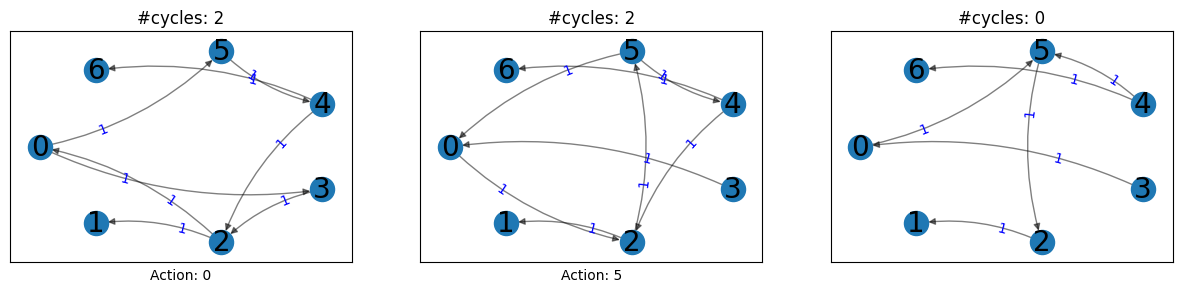

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,3))
for i, graph in enumerate(graphs):
    ax = fig.add_subplot(1, len(graphs), i+1)

    # rows, cols = np.where(graph > 0)
    # edges = zip(rows.tolist(), cols.tolist())
    # gr = nx.DiGraph()
    # pos = nx.spring_layout(gr)
    # gr.add_edges_from(edges)
    graph[graph <= 0] = 0
    gr = nx.from_numpy_array(graph, create_using=nx.MultiDiGraph())

    pos = nx.spring_layout(gr)

    # draw graph
    draw_labeled_multigraph(gr, "weight")
    # nx.draw_networkx(gr, pos=pos, font_size=16, node_color='blue', font_color='white')

    # draw subgraph for highlights
    # if i < len(graphs)-1:
        # nx.draw_networkx(gr.subgraph(moves[i]), pos=pos, font_size=16, node_color='red', font_color='white')

    ax.set_title(f"#cycles: {len([*nx.cycles.simple_cycles(gr)])}")
    if i < len(graphs)-1:
        ax.set_xlabel(f"Action: {moves[i]}")

plt.savefig("RL_walk_3.png")